Time Series Decomposition




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm

Opens (or creates) a file with the specified name (file_name) in write-binary (wb) mode.
Writes the response.content (the raw data from the response) into the file.

In [2]:
import requests
from statsmodels.tsa.stattools import adfuller

# URL of the raw CSV file
git_raw_url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"

# Local file name to save the data
file_name = "airline-passengers.csv"

# Fetch the data from the URL
response = requests.get(git_raw_url)

# Check if the request was successful
if response.status_code == 200:
    with open(file_name, "wb") as file:
        file.write(response.content)
        
    print(f"File saved as {file_name}")
else:
    print(f"Failed to download file. HTTP Status Code: {response.status_code}")


File saved as airline-passengers.csv


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import statsmodels.api as sm

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)


<Axes: xlabel='Month'>

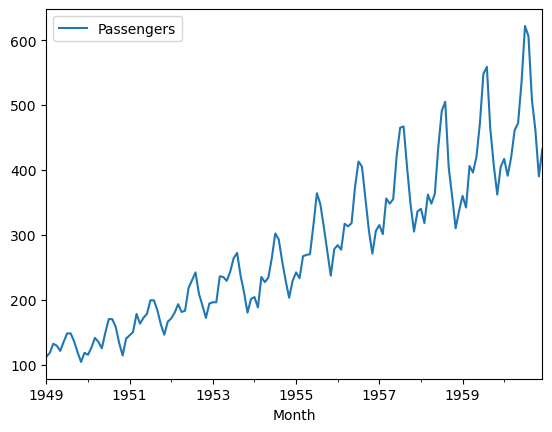

In [4]:
df = pd.read_csv(file_name,header=0, index_col=0, parse_dates=True)
display(df)
print(df.index)
df.plot()

Clearly see some trend and some seasonality
We will assume a multiplicative model.

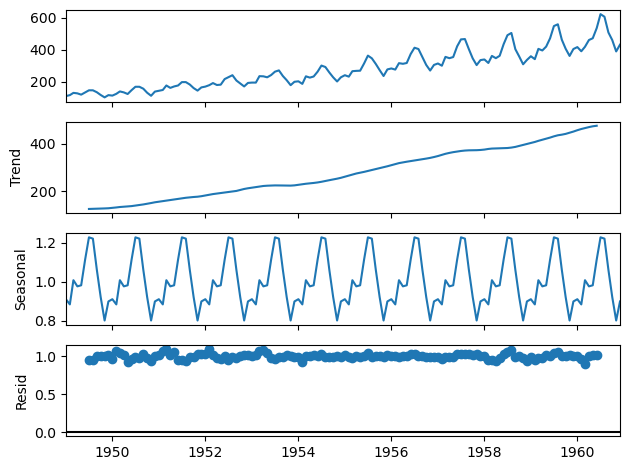

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df,model='multiplicative')
result.plot()
plt.show()

decomposition = pd.DataFrame({
    'observed': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'residual': result.resid
})

Analysis and Forecasting

In [6]:
#Trend
decomposition['trend'].fillna(method='bfill', inplace=True)
decomposition['trend'].fillna(method='ffill', inplace=True)

trend_slope = np.polyfit(range(len(decomposition['trend'])),decomposition['trend'],1)[0]
print(f"Trend SLope:{trend_slope}")

Trend SLope:2.633639277389278


In [7]:
#Seasonality
print(decomposition['seasonal'])
print(decomposition['observed'])

seasonality_strength = np.var(decomposition['seasonal']) / np.var(decomposition['observed'])
print(f"Seasonality Strength: {seasonality_strength}")

Month
1949-01-01    0.910230
1949-02-01    0.883625
1949-03-01    1.007366
1949-04-01    0.975906
1949-05-01    0.981378
                ...   
1960-08-01    1.219911
1960-09-01    1.060492
1960-10-01    0.921757
1960-11-01    0.801178
1960-12-01    0.898824
Name: seasonal, Length: 144, dtype: float64
Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
              ...  
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Name: observed, Length: 144, dtype: float64
Seasonality Strength: 1.134306337705796e-06


In [22]:
#Stationarity

def make_stationary(series, max_diff=5):
    d =0
    while d <= max_diff:
        adf_test = adfuller(series.dropna())
        stationary = adf_test[1] < 0.05
        print("Series is Stationary" if stationary else "Series is Non-Stationary")
        if stationary:
            return series, d
        else:
            series = series.diff().dropna()
            d+=1
            print("Series is Stationary" if stationary else "Series is Non-Stationary")
    return series, d

print(df.columns)
series = df['Passengers']
print(type(series))

df_diff, d_value = make_stationary(series)

adf_test = adfuller(df_diff.dropna())
stationary = adf_test[1] < 0.05
print("Series is Stationary" if stationary else "Series is Non-Stationary")
print(d_value)
print(df_diff)




Index(['Passengers'], dtype='object')
<class 'pandas.core.series.Series'>
Series is Non-Stationary
Series is Non-Stationary
Series is Non-Stationary
Series is Non-Stationary
Series is Stationary
Series is Stationary
2
Month
1949-03-01      8.0
1949-04-01    -17.0
1949-05-01     -5.0
1949-06-01     22.0
1949-07-01     -1.0
              ...  
1960-08-01   -103.0
1960-09-01    -82.0
1960-10-01     51.0
1960-11-01    -24.0
1960-12-01    113.0
Name: Passengers, Length: 142, dtype: float64


In [9]:
#Best Subset Selection Algo
from sklearn.metrics import mean_squared_error

def stepwise_arima_selection(series, max_p = 20, fixed_d= 2, max_q=20):
    best_mse= np.inf
    best_order = None
    best_model = None
    
    for p in range(0,max_p +1):
        for q in range(0,max_q+1):
            try:
                model = ARIMA(series, order=(p,fixed_d,q))
                model_fit = model.fit()
                
                predictions = model_fit.fittedvalues
                
                mse = mean_squared_error(series, predictions)
                
                if mse < best_mse:
                    best_mse = mse
                    best_order = (p,fixed_d,q)
                    best_model = model_fit
                    print(f"New best model found with order {best_order}")
                    
            except Exception as e:
                continue
    print(f"AIC: {model_fit.aic}, BIC: {model_fit.bic}")
    return best_model, best_order, best_mse


df_diff = df_diff.asfreq('MS')  # Set frequency to monthly start ('MS') if it's monthly data

best_model, best_order, best_mse = stepwise_arima_selection(df_diff)
    

New best model found with order (0, 2, 0)
New best model found with order (0, 2, 1)
New best model found with order (0, 2, 2)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


New best model found with order (0, 2, 3)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


New best model found with order (0, 2, 4)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.

New best model found with order (0, 2, 10)
New best model found with order (0, 2, 11)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.

New best model found with order (0, 2, 14)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


New best model found with order (0, 2, 15)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.

New best model found with order (1, 2, 18)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


New best model found with order (1, 2, 20)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib

New best model found with order (8, 2, 10)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


New best model found with order (8, 2, 12)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


New best model found with order (8, 2, 14)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


New best model found with order (8, 2, 15)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.

New best model found with order (8, 2, 19)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive paramet

New best model found with order (11, 2, 2)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


New best model found with order (11, 2, 3)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


New best model found with order (11, 2, 4)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


New best model found with order (11, 2, 5)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


New best model found with order (11, 2, 6)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


New best model found with order (11, 2, 7)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/T

New best model found with order (11, 2, 15)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/T

New best model found with order (12, 2, 18)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/T

New best model found with order (13, 2, 20)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/T

New best model found with order (16, 2, 11)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/T

New best model found with order (16, 2, 20)


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/T

AIC: 1242.8300103637378, BIC: 1363.4373496907192


Month
1949-03-01      8.0
1949-04-01    -17.0
1949-05-01     -5.0
1949-06-01     22.0
1949-07-01     -1.0
              ...  
1960-08-01   -103.0
1960-09-01    -82.0
1960-10-01     51.0
1960-11-01    -24.0
1960-12-01    113.0
Freq: MS, Name: Passengers, Length: 142, dtype: float64
1961-01-01     -7.618527
1961-02-01    -63.981575
1961-03-01     48.919101
1961-04-01     24.443672
1961-05-01    -41.898787
1961-06-01     34.538997
1961-07-01     82.824962
1961-08-01   -170.564363
1961-09-01    -45.354291
1961-10-01     43.546213
1961-11-01    -14.190842
1961-12-01     79.171363
1962-01-01     33.046021
1962-02-01    -85.874413
1962-03-01     29.694744
1962-04-01     62.198500
1962-05-01    -59.632347
1962-06-01     27.980058
1962-07-01     81.555447
1962-08-01   -156.152766
Freq: MS, Name: predicted_mean, dtype: float64
                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  142
Model:       

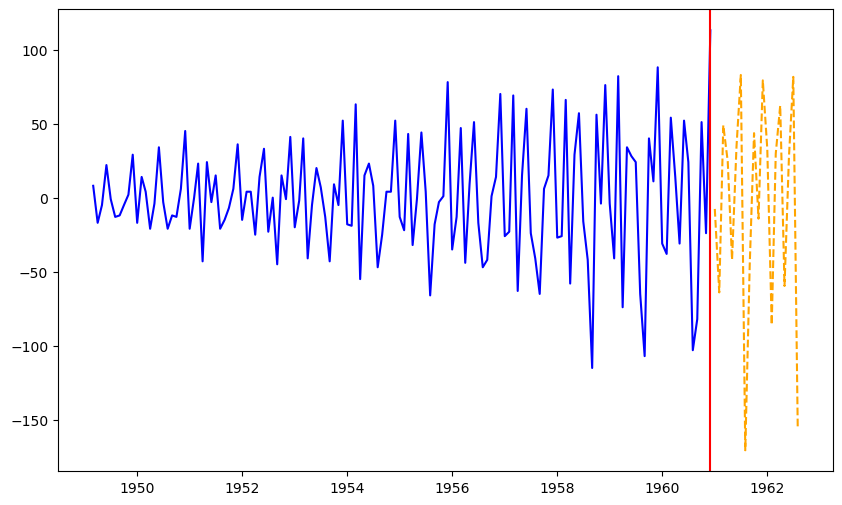

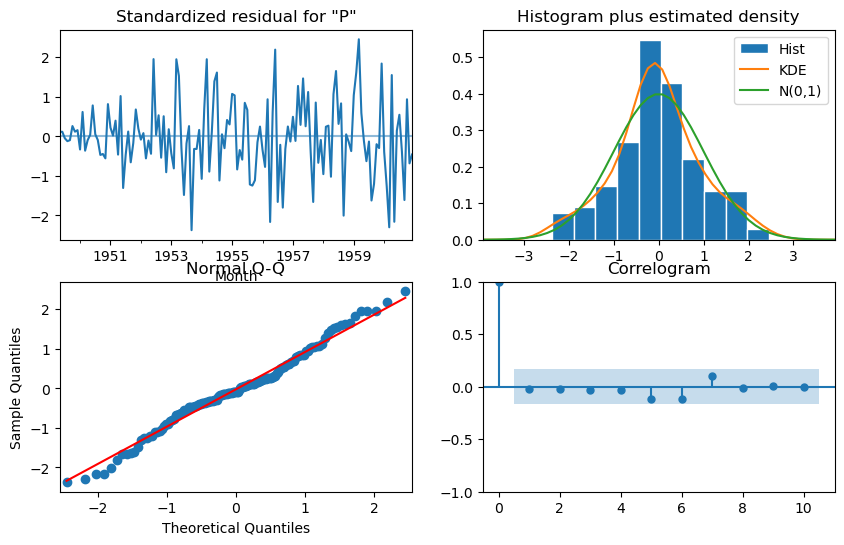

False


In [10]:
#Forecasting
print(df_diff)
forecast_steps = 20
forecast_diff2 = best_model.forecast(steps = forecast_steps)
print(forecast_diff2)

plt.figure(figsize=(10,6))

# Plot the original series
plt.plot(df_diff, label="Original Series", color='blue')
plt.plot(forecast_diff2, label="Forecasted Series", color='orange', linestyle='--')
plt.axvline(x=df.index[-1], color='red', linestyle='-', label="Forecast Start")

print(best_model.summary())  # To check the model summary
# Diagnostics for residuals and model diagnostics
best_model.plot_diagnostics(figsize=(10,6))
plt.show()

print(best_model.mle_retvals['converged'])


In [11]:
# Initialize an empty list to store the forecasted values

forecasted_original = []

# Get the last known values for the original series and first differences
last_original = df['Passengers'].iloc[-1]
last_diff1 = df['Passengers'].iloc[-1] - df['Passengers'].iloc[-2]

for i in range(forecast_steps):
    forecast_diff1 = forecast_diff2[i] + last_diff1
    
    forecasted_value = forecast_diff1 + last_original
    forecasted_original.append(forecasted_value)

    print(f"Step {i + 1}:")
    print(f"forecast_diff2[i]: {forecast_diff2[i]}")
    print(f"last_diff1: {last_diff1}")
    print(f"forecast_diff1: {forecast_diff1}")
    print(f"forecasted_value: {forecasted_value}")
    # Update last_diff1 and last_original for the next step
    last_diff1 = forecast_diff1  # Now the current forecasted first difference is the "last"
    last_original = forecasted_value  # Now the current forecasted value is the "last"

forecasted_original = pd.Series(forecasted_original, index=pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS'))

# Print the forecasted original series
print(forecasted_original)  
    
    

Step 1:
forecast_diff2[i]: -7.61852726251783
last_diff1: 42
forecast_diff1: 34.38147273748217
forecasted_value: 466.38147273748217
Step 2:
forecast_diff2[i]: -63.981575130461124
last_diff1: 34.38147273748217
forecast_diff1: -29.600102392978954
forecasted_value: 436.7813703445032
Step 3:
forecast_diff2[i]: 48.91910114294254
last_diff1: -29.600102392978954
forecast_diff1: 19.318998749963583
forecasted_value: 456.1003690944668
Step 4:
forecast_diff2[i]: 24.44367150904037
last_diff1: 19.318998749963583
forecast_diff1: 43.762670259003954
forecasted_value: 499.86303935347075
Step 5:
forecast_diff2[i]: -41.89878659265949
last_diff1: 43.762670259003954
forecast_diff1: 1.8638836663444636
forecasted_value: 501.7269230198152
Step 6:
forecast_diff2[i]: 34.53899739988748
last_diff1: 1.8638836663444636
forecast_diff1: 36.40288106623194
forecasted_value: 538.1298040860472
Step 7:
forecast_diff2[i]: 82.82496198693698
last_diff1: 36.40288106623194
forecast_diff1: 119.22784305316893
forecasted_value: 65

In [12]:

# Reconstruct the first differenced series from the second differenced forecast

last_diff2 = df_diff.iloc[-1]
forecast_diff1 = forecast_diff2 + last_diff2

last_original = df['Passengers'].iloc[-1]
print(last_original)

forecasted_diff0 = forecast_diff1 + last_original
print(forecasted_original)

432
1961-01-01    466.381473
1961-02-01    436.781370
1961-03-01    456.100369
1961-04-01    499.863039
1961-05-01    501.726923
1961-06-01    538.129804
1961-07-01    657.357647
1961-08-01    606.021127
1961-09-01    509.330316
1961-10-01    456.185719
1961-11-01    388.850279
1961-12-01    400.686203
1962-01-01    445.568149
1962-02-01    404.575680
1962-03-01    393.277956
1962-04-01    444.178731
1962-05-01    435.447160
1962-06-01    454.695646
1962-07-01    555.499579
1962-08-01    500.150746
Freq: MS, dtype: float64


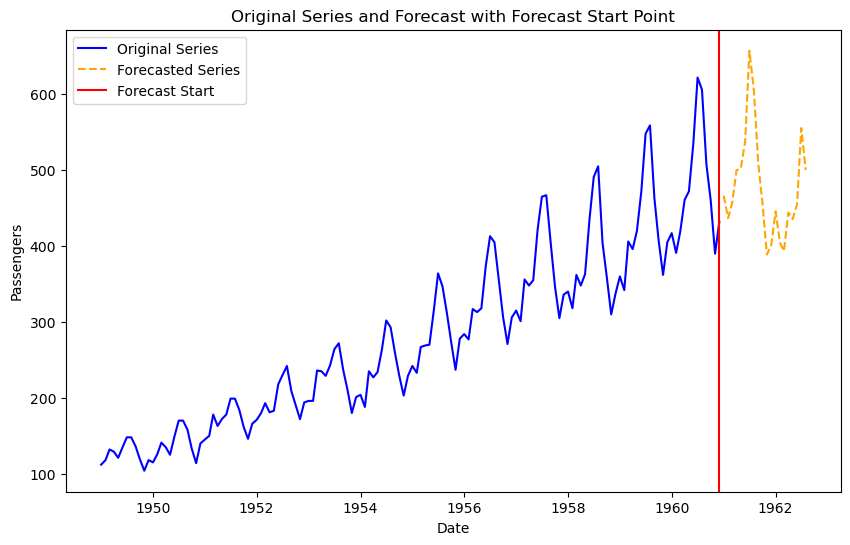

In [13]:
plt.figure(figsize=(10,6))

# Plot the original series
plt.plot(df, label="Original Series", color='blue')
plt.plot(forecasted_original, label="Forecasted Series", color='orange', linestyle='--')
plt.axvline(x=df.index[-1], color='red', linestyle='-', label="Forecast Start")

plt.title("Original Series and Forecast with Forecast Start Point")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()


Issues of values converging to negative numbers likely due to the ARIMA model's limitations when applied to time series data with a clear positive trend and seasonality. 

Given your time series exhibits clear positive trend and seasonality, you might want to try SARIMA, Holt-Winters Exponential Smoothing, or Prophet



Adding Cross-validation 

Rolling Window Cross-Validation: You fix the training window size (e.g., 100 data points), and as you move forward in time, you slide the window (i.e., shift the training set forward) while keeping the test set fixed. This helps simulate how the model will perform on future unseen data.

In [39]:
def rollowing_window_cross(series, max_p, max_q, fixed_d, window_size, forecast_steps):
    best_mse = np.inf
    best_model = None
    best_order = None
    
    n = len(series)
    for p in range(0,max_p+1):
        for q in range(0,max_q+1):
            mse_list=[]
            
            #start rolling window cross val
            for start in range(window_size,n-forecast_steps+1,window_size):
                train = series[start:start+forecast_steps]
                test = series[start:start+forecast_steps]
                
                try:
                    model = ARIMA(train, order=(p, fixed_d, q))
                    model_fit = model.fit()

                    # Forecast the test data
                    forecast = model_fit.forecast(steps=forecast_steps)

                    # Calculate MSE
                    mse = mean_squared_error(test, forecast)
                    mse_list.append(mse)
                
                except Exception as e:
                    continue
                    
            avg_mse = np.mean(mse_list)
            
            if avg_mse < best_mse:
                best_mse = avg_mse
                best_order = (p,fixed_d,q)
                best_model = model_fit
                print(f"New best model found with order {best_order} and MSE {best_mse}")
    
    
    print(f"AIC: {model_fit.aic}, BIC: {model_fit.bic}")
    return best_model, best_order, best_mse

best_model, best_order, best_mse = rollowing_window_cross(df_diff,20,20,2,100,20)
                
    
    
    

/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information 

New best model found with order (0, 2, 0) and MSE 230848.35000000434
New best model found with order (0, 2, 1) and MSE 4756.512718697176
New best model found with order (0, 2, 2) and MSE 2671.503910847555


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarnin

New best model found with order (0, 2, 5) and MSE 2636.3996742368213


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too

New best model found with order (0, 2, 6) and MSE 2630.589887754499


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too

New best model found with order (1, 2, 7) and MSE 2623.9960583277125


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too

New best model found with order (2, 2, 1) and MSE 2527.0661340000424


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

New best model found with order (5, 2, 12) and MSE 2372.099777124645


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too

AIC: 286.19504991586894, BIC: 322.7002919896117


/opt/anaconda3/envs/Test1/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Neural Net for identifying (p,d,q) Instead of best subset algo.

Goal:
Build a simple feed-forward neural network that takes as input the ARIMA parameters 
𝑝
p and 
𝑞
q and outputs a predicted MSE.

Architecture:
Input Layer: 2 neurons (one for 
𝑝
p and one for 
𝑞
q).
Hidden Layers: One or more Dense layers (e.g., 64 neurons in the first layer and 32 in the second) with ReLU activations.
Output Layer: A single neuron with a linear activation function (since MSE is a continuous number).
Preprocessing:
Scaling:
Since 
𝑝
p and 
𝑞
q are integer values, it’s often a good idea to scale them (e.g., using StandardScaler) so that the network training is more stable.

2 hidden layers with 64 and 32 neurons is a common heuristic when building a feedforward neural network for a relatively simple regression problem. Here’s the rationale behind it:

Heuristic Starting Point:
When you have a small number of input features (in our case, just 2: the ARIMA parameters 
𝑝
p and 
𝑞
q), a network with one or two hidden layers is often sufficient to capture the underlying relationship. We start with a moderately sized network and then adjust based on performance.

Number of Neurons (64 and 32):

64 neurons in the first hidden layer: This gives the network enough capacity to learn complex interactions between the input parameters and the output (MSE) without being too large.
32 neurons in the second hidden layer: This reduces the dimensionality further, helping the network to consolidate and abstract the learned features before reaching the output layer.
Essentially, the network gradually compresses the information through the layers, which often helps with generalization.

In [ ]:
#Fitting a Neural Net

def generate_ARIMA(series, max_p, fixed_d, max_q):
    data = []
    for p in range(max_p+1):
        for q in range(max_q+1):
            try:
                model = ARIMA(series, order=(p, fixed_d, q))
                model_fit = model.fit()
                prediction = model_fit.fittedvalues
                mse = mean_squared_error(series, prediction)
                data.append([p,q,mse])
            except Exception as e:
                continue
    df = pd.DataFrame(data, columns=['p', 'q', 'mse'])
    return df


arima_data = generate_ARIMA(df_diff, 20, d_value, 20)




In [3]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler


X = arima_data[['p','q']].values
y = arima_data['mse'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(64, input_dim=2, activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,))

model.compile(loss='mse', optimizer='adam')

model.fit(X_train, y_train, validation_data=(X_test, y_test))




2025-03-08 16:10:16.245462: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
print(best_order)
forecast_steps = 20
forecast_diff2 = best_model.forecast(steps = forecast_steps)
print(type(forecast_diff2))
print(type(df_diff))

(5, 2, 12)
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


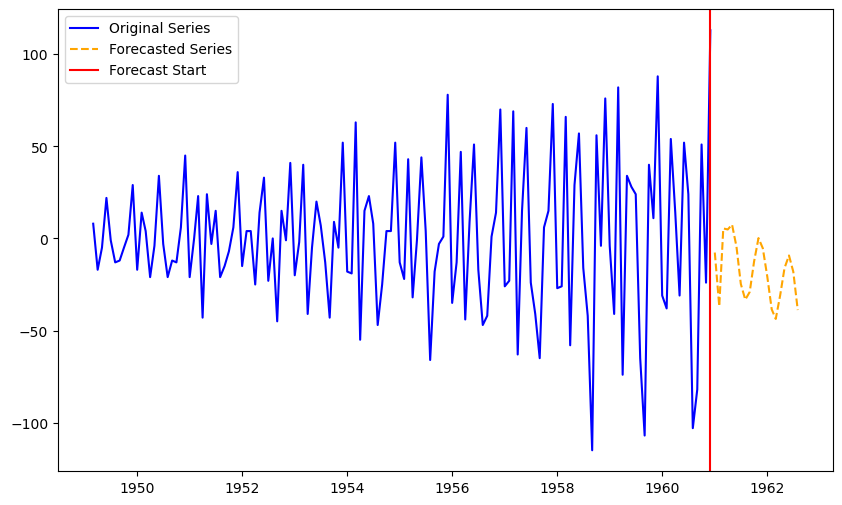

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                   20
Model:                ARIMA(5, 2, 12)   Log Likelihood                -101.337
Date:                Tue, 04 Mar 2025   AIC                            238.674
Time:                        14:48:25   BIC                            254.701
Sample:                    07-01-1957   HQIC                           240.884
                         - 02-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2472    159.153     -0.008      0.994    -313.181     310.686
ar.L2         -0.5935    143.435     -0.004      0.997    -281.721     280.534
ar.L3         -0.6105    145.106     -0.004      0.9

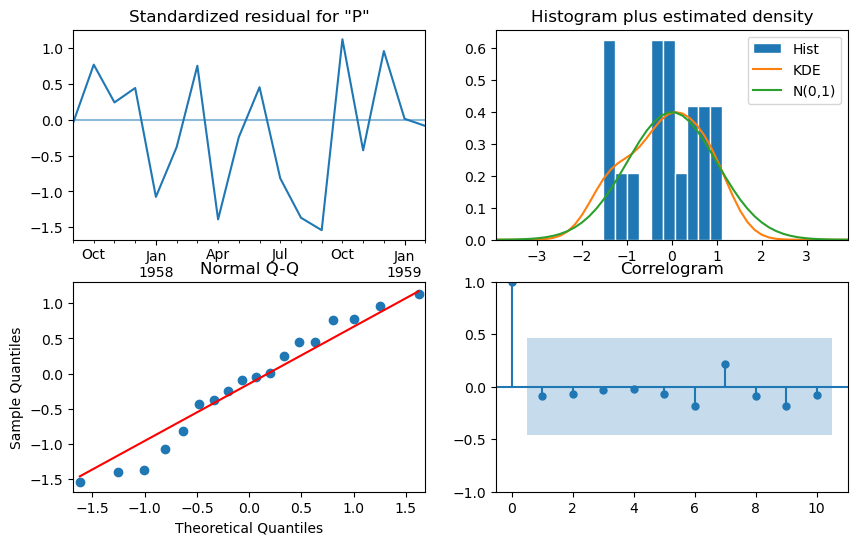

False


In [41]:
forecast_index = pd.date_range(df_diff.index[-1]+pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
forecast_diff2.index = forecast_index

# Plot the original series and forecasted series
plt.figure(figsize=(10,6))
plt.plot(df_diff, label="Original Series", color='blue')
plt.plot(forecast_diff2, label="Forecasted Series", color='orange', linestyle='--')

# Plot the vertical line to indicate the forecast start point
plt.axvline(x=df_diff.index[-1], color='red', linestyle='-', label="Forecast Start")

# Show the plot
plt.legend()
plt.show()

print(best_model.summary())  # To check the model summary
# Diagnostics for residuals and model diagnostics
best_model.plot_diagnostics(figsize=(10,6))
plt.show()

print(best_model.mle_retvals['converged'])

In [42]:

forecasted_original = []

# Get the last known values for the original series and first differences
last_original = df['Passengers'].iloc[-1]
last_diff1 = df['Passengers'].iloc[-1] - df['Passengers'].iloc[-2]

for i in range(forecast_steps):
    forecast_diff1 = forecast_diff2[i] + last_diff1

    forecasted_value = forecast_diff1 + last_original
    forecasted_original.append(forecasted_value)

    print(f"Step {i + 1}:")
    print(f"forecast_diff2[i]: {forecast_diff2[i]}")
    print(f"last_diff1: {last_diff1}")
    print(f"forecast_diff1: {forecast_diff1}")
    print(f"forecasted_value: {forecasted_value}")
    # Update last_diff1 and last_original for the next step
    last_diff1 = forecast_diff1  # Now the current forecasted first difference is the "last"
    last_original = forecasted_value  # Now the current forecasted value is the "last"

forecasted_original = pd.Series(forecasted_original, index=pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS'))

# Print the forecasted original series
print(forecasted_original)  
    
    

Step 1:
forecast_diff2[i]: -7.659841385647383
last_diff1: 42
forecast_diff1: 34.34015861435262
forecasted_value: 466.3401586143526
Step 2:
forecast_diff2[i]: -36.809996315735034
last_diff1: 34.34015861435262
forecast_diff1: -2.469837701382417
forecasted_value: 463.8703209129702
Step 3:
forecast_diff2[i]: 5.440008969508824
last_diff1: -2.469837701382417
forecast_diff1: 2.970171268126407
forecasted_value: 466.84049218109664
Step 4:
forecast_diff2[i]: 4.863335172656342
last_diff1: 2.970171268126407
forecast_diff1: 7.833506440782749
forecasted_value: 474.6739986218794
Step 5:
forecast_diff2[i]: 7.511985873013387
last_diff1: 7.833506440782749
forecast_diff1: 15.345492313796136
forecasted_value: 490.0194909356755
Step 6:
forecast_diff2[i]: -4.571580935469171
last_diff1: 15.345492313796136
forecast_diff1: 10.773911378326964
forecasted_value: 500.79340231400244
Step 7:
forecast_diff2[i]: -24.6873729675519
last_diff1: 10.773911378326964
forecast_diff1: -13.913461589224937
forecasted_value: 486.

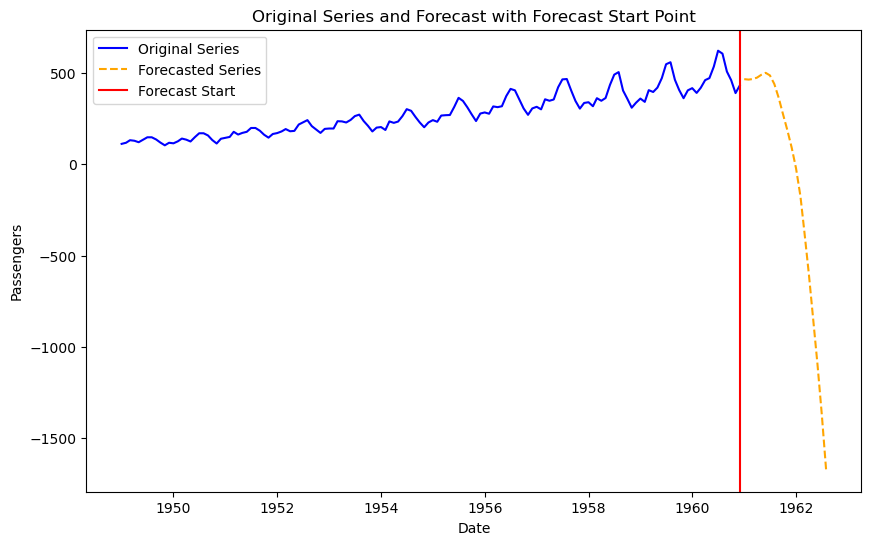

In [43]:
plt.figure(figsize=(10,6))

# Plot the original series
plt.plot(df, label="Original Series", color='blue')
plt.plot(forecasted_original, label="Forecasted Series", color='orange', linestyle='--')
plt.axvline(x=df.index[-1], color='red', linestyle='-', label="Forecast Start")

plt.title("Original Series and Forecast with Forecast Start Point")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()
